In [ ]:
#THIS PROGRAM WAS WRITTEN WITH THE HELP OF CHATGPT 5 WITH THE INTENTION TO CREATE AN APPLICATION THAT CAN INGEST PAITNINGS
#AND OUTPUT A MUSICAL REPRESENTATION OF THE PAINTING USING AI MODELS.
#IT IS THE LAST STEP OF MY GOAL TO INVESTIGATE DIFFERENT WAYS OF SONIFYING PAINTINGS USING AI..
#PLEASE REFER TO MY SLIDES FOR MORE INSIGHTS ON MY EXERCISE DELIVERY.

# Cell 1 – Basic setup: install needed packages, fix Mac OpenMP issue, and import libraries

# 👉 This environment variable fixes a common Mac error (OpenMP / libomp)
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 👉 Install all required libraries (run this once; then you can comment it out)
# If they are already installed, you can put a # in front of the next line.
!pip install torch torchvision pillow scikit-learn midiutil ipympl

# 👉 Now import all the Python libraries we need
from pathlib import Path

from PIL import Image

import torch
from torchvision import models, transforms

from sklearn.decomposition import PCA
import numpy as np

from midiutil import MIDIFile

import matplotlib.pyplot as plt

print("Setup done, libraries imported.")


Setup done, libraries imported.


In [2]:
# Cell 2 – Enable interactive plots (needed for clickable PCA map later)

# 👉 This tells matplotlib to use an interactive widget backend instead of static images.
#    It enables clicking, zooming, etc., inside the notebook.
%matplotlib widget

print("Interactive plotting enabled.")


Interactive plotting enabled.


In [3]:
# Cell 3 – Set up folders for your paintings and MIDI output

# 👉 Folder where you put your mom's paintings (JPG/PNG)
IMAGES_DIR = Path("images")

# 👉 Folder where MIDI files will be saved
MIDI_DIR = Path("midi")
MIDI_DIR.mkdir(exist_ok=True)

print("Images folder:", IMAGES_DIR.resolve())
print("MIDI folder:  ", MIDI_DIR.resolve())


Images folder: /Users/Samuel_Flueckiger/Desktop/CAS_AICP/Module 3 - Sound/Exercise Module 3/Image_Sonification/images
MIDI folder:   /Users/Samuel_Flueckiger/Desktop/CAS_AICP/Module 3 - Sound/Exercise Module 3/Image_Sonification/midi


In [4]:
# Cell 4 – List all paintings found in the images folder

def list_image_files(folder: Path):
    # 👉 We accept .jpg, .jpeg, .png
    exts = (".jpg", ".jpeg", ".png")
    return sorted([p for p in folder.iterdir() if p.suffix.lower() in exts])

image_paths = list_image_files(IMAGES_DIR)

print(f"Found {len(image_paths)} images:")
for p in image_paths:
    print(" -", p.name)


Found 45 images:
 - 01.jpg
 - 02.jpg
 - 03.jpg
 - 04.jpg
 - 05.jpg
 - 06.jpg
 - 07.jpg
 - 08.jpg
 - 09.jpg
 - 10.jpg
 - 11.jpg
 - 12.jpg
 - 13.jpg
 - 14.jpg
 - 15.jpg
 - 16.jpg
 - 17.jpg
 - 18.jpg
 - 19.jpg
 - 20.jpg
 - 21.jpg
 - 22.jpg
 - 23.jpg
 - 24.jpg
 - 25.jpg
 - 26.jpg
 - 27.jpg
 - 28.jpg
 - 29.jpg
 - 30.jpg
 - 31.jpg
 - 32.jpg
 - 33.jpg
 - 34.jpg
 - 35.jpg
 - 36.jpg
 - 37.jpg
 - 38.jpg
 - 39.jpg
 - 40.jpg
 - 41.jpg
 - 42.jpg
 - 43.jpg
 - 44.jpg
 - 45.jpg


In [5]:
# Cell 5 – Load ResNet18 (pre-trained neural network) and image preprocessing

def load_resnet_feature_extractor():
    """
    Load a pre-trained ResNet18 model and turn it into a feature extractor
    by removing the final classification layer.
    """
    # 👉 Load a ResNet18 model trained on ImageNet
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    resnet.eval()  # evaluation mode (we don't train it)

    # 👉 Remove the last layer so we just get a 512-dim feature vector
    feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
    return feature_extractor

def get_preprocess_transform():
    """
    Define how each image should be prepared before entering ResNet:
    - Resize
    - Center crop
    - Convert to tensor
    - Normalize with ImageNet mean/std
    """
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])

feature_extractor = load_resnet_feature_extractor()
preprocess = get_preprocess_transform()

print("ResNet18 feature extractor ready.")


ResNet18 feature extractor ready.


In [6]:
# Cell 6 – Extract feature embeddings (512 numbers) for each painting

def extract_embedding(image_path: Path, feature_extractor, preprocess) -> np.ndarray:
    """
    Take one painting image, run it through ResNet,
    and get a 512-dimensional feature vector (embedding).
    """
    img = Image.open(image_path).convert("RGB")
    x = preprocess(img).unsqueeze(0)  # shape: (1, 3, 224, 224)

    with torch.no_grad():
        feat = feature_extractor(x)   # shape: (1, 512, 1, 1)

    return feat.squeeze().numpy()     # shape: (512,)

embeddings = []

for img_path in image_paths:
    print("Extracting features from:", img_path.name)
    emb = extract_embedding(img_path, feature_extractor, preprocess)
    embeddings.append(emb)

X = np.stack(embeddings)  # shape: (N_images, 512)
print("Embeddings shape:", X.shape)


Extracting features from: 01.jpg
Extracting features from: 02.jpg
Extracting features from: 03.jpg
Extracting features from: 04.jpg
Extracting features from: 05.jpg
Extracting features from: 06.jpg
Extracting features from: 07.jpg
Extracting features from: 08.jpg
Extracting features from: 09.jpg
Extracting features from: 10.jpg
Extracting features from: 11.jpg
Extracting features from: 12.jpg
Extracting features from: 13.jpg
Extracting features from: 14.jpg
Extracting features from: 15.jpg
Extracting features from: 16.jpg
Extracting features from: 17.jpg
Extracting features from: 18.jpg
Extracting features from: 19.jpg
Extracting features from: 20.jpg
Extracting features from: 21.jpg
Extracting features from: 22.jpg
Extracting features from: 23.jpg
Extracting features from: 24.jpg
Extracting features from: 25.jpg
Extracting features from: 26.jpg
Extracting features from: 27.jpg
Extracting features from: 28.jpg
Extracting features from: 29.jpg
Extracting features from: 30.jpg
Extracting

In [7]:
# Cell 7 – Run PCA to reduce each 512-dim feature vector down to 4 numbers

N_COMPONENTS = 4  # 👉 We keep 4 principal components (PC1–PC4)

pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(X)  # shape: (N_images, 4)

print("PCA shape:", X_pca.shape)
print("Explained variance ratios:", pca.explained_variance_ratio_)


PCA shape: (45, 4)
Explained variance ratios: [0.16368683 0.08379069 0.07679235 0.05135702]


In [8]:
# Cell 8 – Compute min and max of each PCA component across all paintings

# 👉 These values tell us how large/small PC1, PC2, PC3, PC4 get in your dataset.
#    We use them to map PCA values into musical ranges (pitch, tempo, etc.).

PC_MINS = X_pca.min(axis=0)
PC_MAXS = X_pca.max(axis=0)

print("PC mins:", PC_MINS)
print("PC maxs:", PC_MAXS)


PC mins: [ -9.486673 -10.905151 -12.322738 -11.793923]
PC maxs: [10.166197 10.673155  6.549984  8.813468]


In [9]:
# Cell 9 – Map numbers between ranges and get basic musical parameters from PCA

def normalize_value(x, old_min, old_max, new_min, new_max):
    """
    Linearly map x from [old_min, old_max] to [new_min, new_max].
    If old_min == old_max, return the midpoint of the new range.
    """
    if old_min == old_max:
        return (new_min + new_max) / 2.0
    return new_min + (x - old_min) * (new_max - new_min) / (old_max - old_min)


def get_params_for_pca(pca_vec):
    """
    Turn one 4D PCA vector (PC1–PC4) into basic musical parameters:
    - base pitch
    - tempo in BPM
    - notes per bar (density)
    - velocity (loudness)
    """
    pc1, pc2, pc3, pc4 = pca_vec

    old_min1, old_max1 = PC_MINS[0], PC_MAXS[0]
    old_min2, old_max2 = PC_MINS[1], PC_MAXS[1]
    old_min3, old_max3 = PC_MINS[2], PC_MAXS[2]
    old_min4, old_max4 = PC_MINS[3], PC_MAXS[3]

    base_pitch   = int(normalize_value(pc1, old_min1, old_max1, 48, 72))   # C3–C5
    bpm          = int(normalize_value(pc2, old_min2, old_max2, 60, 140))  # tempo
    note_density = int(normalize_value(pc3, old_min3, old_max3, 2, 10))    # notes per bar
    velocity     = int(normalize_value(pc4, old_min4, old_max4, 60, 120))  # loudness

    # Safety: clamp BPM to a reasonable positive range
    bpm = max(40, min(bpm, 240))

    return base_pitch, bpm, note_density, velocity

print("Helper functions for mapping PCA to sound ready.")


Helper functions for mapping PCA to sound ready.


In [10]:
# Cell 10 – Choose a melodic interval pattern (motif) based on PCA values

def choose_interval_pattern(pca_vec):
    """
    Choose one of several melodic interval patterns based on PCA values.
    This makes each painting have a different melodic "shape".
    """
    pc3 = pca_vec[2]
    pc4 = pca_vec[3]

    # 👉 Use PC3 to pick which pattern we use
    old_min3, old_max3 = PC_MINS[2], PC_MAXS[2]
    pc3_norm = normalize_value(pc3, old_min3, old_max3, 0.0, 1.0)

    # 👉 Define a small library of interval patterns (in semitones)
    patterns = [
        [0, 2, 4, 7],         # bright major-ish arpeggio
        [0, 3, 7, 10],        # minor 7 arpeggio (moody)
        [0, 5, 7, 12],        # open fifths + octave (spacious)
        [0, 1, 5, 8],         # cluster / tension
        [0, -2, -5, -7],      # descending / melancholic
    ]

    # 👉 Map normalized PC3 to a pattern index
    idx = int(pc3_norm * (len(patterns) - 1) + 0.0001)
    base_pattern = patterns[idx]

    # 👉 Use PC4 to decide if we sometimes jump an octave
    old_min4, old_max4 = PC_MINS[3], PC_MAXS[3]
    pc4_norm = normalize_value(pc4, old_min4, old_max4, 0.0, 1.0)
    use_octave_jumps = pc4_norm > 0.6  # high PC4 → more energetic → octave jumps

    return base_pattern, use_octave_jumps

print("Interval pattern chooser ready.")


Interval pattern chooser ready.


In [11]:
# Cell 11 – Create one MIDI file from one PCA vector (uses motif + octave jumps)

def create_midi_from_pca(pca_vec, out_path: Path):
    """
    Use PCA values to create a short 4-bar MIDI piece:
    - PC1, PC2, PC3, PC4 → pitch, tempo, density, velocity
    - Interval pattern and octave jumps chosen by choose_interval_pattern()
    """
    # 👉 Get basic musical parameters
    base_pitch, bpm, note_density, velocity = get_params_for_pca(pca_vec)

    # 👉 Get motif (intervals) and whether to use octave jumps
    intervals, use_octave_jumps = choose_interval_pattern(pca_vec)

    midi = MIDIFile(1)
    track = 0
    midi.addTempo(track, 0, bpm)

    n_bars = 4
    beats_per_bar = 4.0

    for bar in range(n_bars):
        for i in range(note_density):
            beat_length = beats_per_bar / note_density
            note_start  = bar * beats_per_bar + i * beat_length
            duration    = beat_length * 0.8

            # 👉 Choose interval from pattern
            interval = intervals[i % len(intervals)]
            pitch = base_pitch + interval

            # 👉 Optional octave jumps for high-energy paintings
            if use_octave_jumps and (i % 3 == 0):
                pitch += 12

            midi.addNote(track, 0, pitch, note_start, duration, velocity)

    with open(out_path, "wb") as f:
        midi.writeFile(f)

    print("Saved MIDI:", out_path.name)

print("MIDI creation function ready.")


MIDI creation function ready.


In [12]:
# Cell 12 – Loop over all paintings and create one MIDI per painting

for pca_vec, img_path in zip(X_pca, image_paths):
    midi_name = img_path.stem + ".mid"  # same name as the image, .mid extension
    midi_path = MIDI_DIR / midi_name
    create_midi_from_pca(pca_vec, midi_path)

print("\nDone! All MIDI files written to the 'midi/' folder.")


Saved MIDI: 01.mid
Saved MIDI: 02.mid
Saved MIDI: 03.mid
Saved MIDI: 04.mid
Saved MIDI: 05.mid
Saved MIDI: 06.mid
Saved MIDI: 07.mid
Saved MIDI: 08.mid
Saved MIDI: 09.mid
Saved MIDI: 10.mid
Saved MIDI: 11.mid
Saved MIDI: 12.mid
Saved MIDI: 13.mid
Saved MIDI: 14.mid
Saved MIDI: 15.mid
Saved MIDI: 16.mid
Saved MIDI: 17.mid
Saved MIDI: 18.mid
Saved MIDI: 19.mid
Saved MIDI: 20.mid
Saved MIDI: 21.mid
Saved MIDI: 22.mid
Saved MIDI: 23.mid
Saved MIDI: 24.mid
Saved MIDI: 25.mid
Saved MIDI: 26.mid
Saved MIDI: 27.mid
Saved MIDI: 28.mid
Saved MIDI: 29.mid
Saved MIDI: 30.mid
Saved MIDI: 31.mid
Saved MIDI: 32.mid
Saved MIDI: 33.mid
Saved MIDI: 34.mid
Saved MIDI: 35.mid
Saved MIDI: 36.mid
Saved MIDI: 37.mid
Saved MIDI: 38.mid
Saved MIDI: 39.mid
Saved MIDI: 40.mid
Saved MIDI: 41.mid
Saved MIDI: 42.mid
Saved MIDI: 43.mid
Saved MIDI: 44.mid
Saved MIDI: 45.mid

Done! All MIDI files written to the 'midi/' folder.


In [13]:
# Cell 13 – Show a table: painting → pitch, BPM, notes/bar, velocity

print(f"{'Painting':30s}  {'Pitch':>5s}  {'BPM':>5s}  {'Notes/Bar':>9s}  {'Velocity':>8s}")
print("-" * 70)

for pca_vec, img_path in zip(X_pca, image_paths):
    base_pitch, bpm, note_density, velocity = get_params_for_pca(pca_vec)
    print(f"{img_path.stem:30s}  {base_pitch:5d}  {bpm:5d}  {note_density:9d}  {velocity:8d}")


Painting                        Pitch    BPM  Notes/Bar  Velocity
----------------------------------------------------------------------
01                                 69     94          8       103
02                                 53    109          7       102
03                                 51    140          5        81
04                                 59    123          6       108
05                                 64     95          4        99
06                                 67    109          4       106
07                                 54    126          4        69
08                                 49    131          8        91
09                                 55     82          9        93
10                                 63    103          8        91
11                                 49     70          7        81
12                                 56     84          6        88
13                                 51    131          9        95
14   

In [14]:
# Cell 14 – Synthesize sound directly in Python for one painting (simple sine instrument)

from IPython.display import Audio, display

def synthesize_from_pca_index(idx, seconds_limit=8.0, sample_rate=22050):
    """
    Create a short audio clip for painting #idx based on:
    - base pitch, BPM, note density, velocity
    - interval pattern + octave jumps
    We use simple sine waves as our "instrument".
    """
    pca_vec = X_pca[idx]

    # 👉 Basic parameters
    base_pitch, bpm, note_density, velocity = get_params_for_pca(pca_vec)
    intervals, use_octave_jumps = choose_interval_pattern(pca_vec)

    # 👉 Convert velocity (0–127) to amplitude (0–1-ish)
    amp = velocity / 127.0

    # 👉 Calculate total duration for 4 bars
    seconds_per_beat = 60.0 / bpm
    beats_per_bar = 4.0
    n_bars = 4
    total_duration = n_bars * beats_per_bar * seconds_per_beat

    # 👉 Safety cap
    total_duration = min(total_duration, seconds_limit)

    n_samples = int(total_duration * sample_rate)
    audio = np.zeros(n_samples, dtype=np.float32)

    for bar in range(n_bars):
        for i in range(note_density):
            beat_length = beats_per_bar / note_density
            note_start_beats = bar * beats_per_bar + i * beat_length
            note_start_time = note_start_beats * seconds_per_beat
            note_duration_time = beat_length * 0.8 * seconds_per_beat

            if note_start_time >= total_duration:
                continue

            interval = intervals[i % len(intervals)]
            pitch = base_pitch + interval
            if use_octave_jumps and (i % 3 == 0):
                pitch += 12

            # 👉 Convert MIDI pitch to frequency in Hz
            freq = 440.0 * 2 ** ((pitch - 69) / 12.0)

            start_idx = int(note_start_time * sample_rate)
            end_idx = int(min((note_start_time + note_duration_time) * sample_rate, n_samples))

            t = np.linspace(0, (end_idx - start_idx) / sample_rate, end_idx - start_idx, endpoint=False)

            # 👉 Simple fade-out envelope
            envelope = np.linspace(1.0, 0.0, len(t), endpoint=False)
            wave = amp * envelope * np.sin(2 * np.pi * freq * t)

            audio[start_idx:end_idx] += wave.astype(np.float32)

    # 👉 Normalize to avoid clipping
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val

    return Audio(audio, rate=sample_rate, autoplay=True)

print("Audio synthesizer ready.")


Audio synthesizer ready.


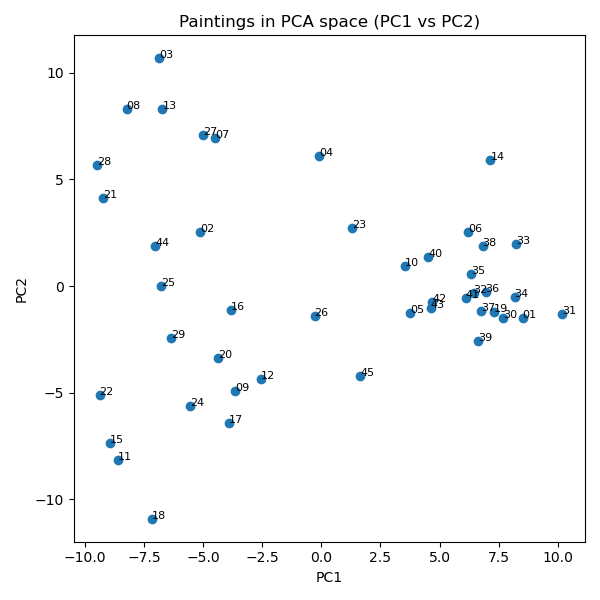

In [15]:
# Cell 15 – Basic PCA scatter plot (PC1 vs PC2, text labels)

plt.figure(figsize=(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])

for (x, y), p in zip(X_pca[:, :2], image_paths):
    plt.text(x, y, p.stem, fontsize=8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Paintings in PCA space (PC1 vs PC2)")
plt.tight_layout()
plt.show()


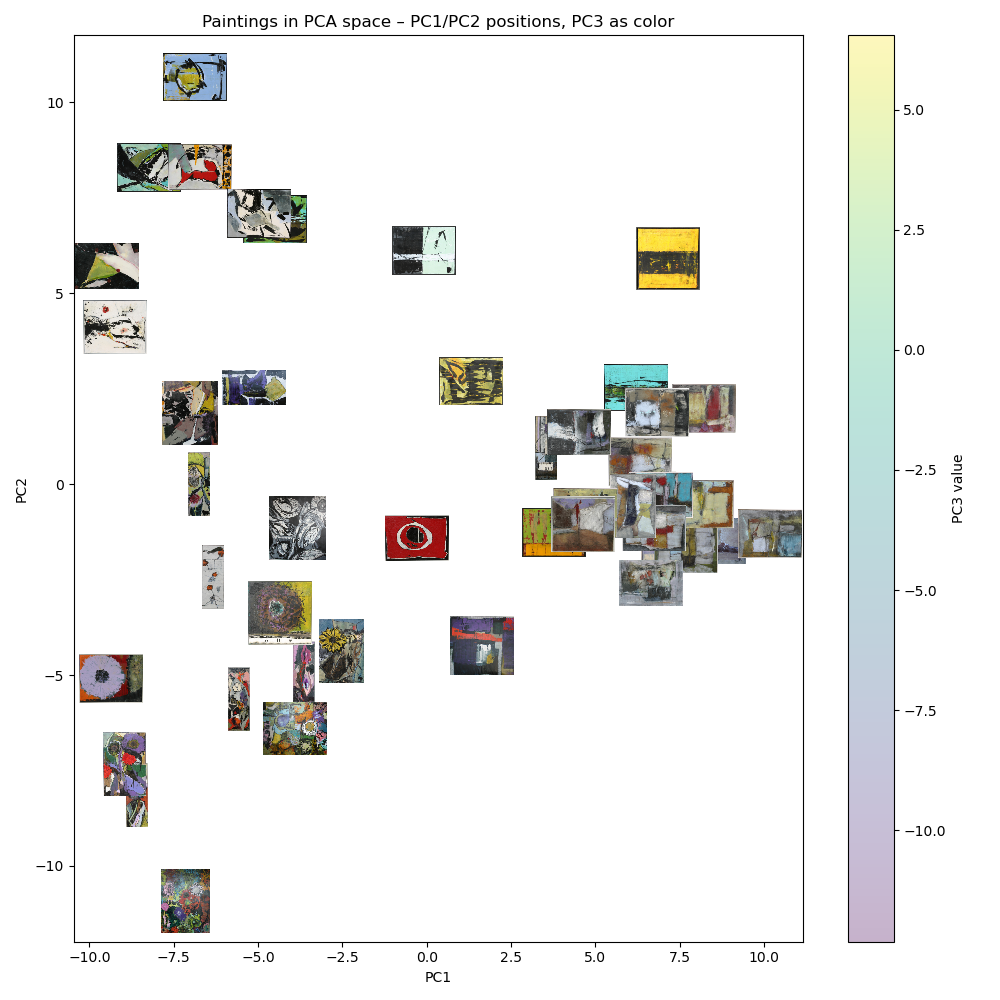

In [16]:
# Cell 16 – PCA plot with thumbnails placed at (PC1, PC2), PC3 shown as color

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def get_thumbnail(path, zoom=0.15):
    """
    Load an image and convert it into a small thumbnail for plotting.
    """
    img = Image.open(path).convert("RGB")
    img.thumbnail((256, 256))
    return OffsetImage(img, zoom=zoom)

plt.figure(figsize=(10, 10))
ax = plt.gca()

# 👉 Use PC3 as color
pc3_values = X_pca[:, 2]

# Faint background scatter just for the color scale
sc = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pc3_values,
    cmap="viridis",
    alpha=0.3,
    s=50
)

# 👉 Add thumbnails at PC1/PC2 positions
for (x, y), img_path in zip(X_pca[:, :2], image_paths):
    try:
        imagebox = get_thumbnail(img_path, zoom=0.18)
        ab = AnnotationBbox(
            imagebox,
            (x, y),
            frameon=False,
            pad=0.0
        )
        ax.add_artist(ab)
    except Exception as e:
        print(f"Could not load {img_path.name}: {e}")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Paintings in PCA space – PC1/PC2 positions, PC3 as color")

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("PC3 value")

plt.tight_layout()
plt.show()


In [17]:
# New Cell – Interactive selector: choose a painting, see it, hear it, and read an explanation

import ipywidgets as widgets
from IPython.display import display, clear_output

# Helper: map interval patterns to text descriptions
def describe_pattern(intervals):
    pattern_map = {
        (0, 2, 4, 7):   "bright, major-like arpeggio",
        (0, 3, 7, 10):  "moody, minor-7 arpeggio",
        (0, 5, 7, 12):  "open, spacious fifths and octave",
        (0, 1, 5, 8):   "tense, clustered pattern",
        (0, -2, -5, -7): "descending, melancholic contour",
    }
    return pattern_map.get(tuple(intervals), "custom interval pattern")

# Helper: convert MIDI note number (e.g. 60) to note name (e.g. C4)
def midi_note_to_name(midi_note):
    note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    octave = (midi_note // 12) - 1
    name = note_names[midi_note % 12]
    return f"{name}{octave}"

# Dropdown with all paintings
painting_options = [(p.stem, i) for i, p in enumerate(image_paths)]
dropdown = widgets.Dropdown(
    options=painting_options,
    description="Painting:",
    layout=widgets.Layout(width="50%")
)

# Output areas for image, text, and audio
image_out = widgets.Output()
text_out = widgets.Output()
audio_out = widgets.Output()

def on_painting_change(change):
    if change["name"] != "value":
        return

    idx = change["new"]
    pca_vec = X_pca[idx]
    pc1, pc2, pc3, pc4 = pca_vec
    img_path = image_paths[idx]

    # Clear old outputs
    image_out.clear_output()
    text_out.clear_output()
    audio_out.clear_output()

    # Compute musical parameters
    base_pitch, bpm, note_density, velocity = get_params_for_pca(pca_vec)
    intervals, use_octave_jumps = choose_interval_pattern(pca_vec)
    pattern_desc = describe_pattern(intervals)
    note_name = midi_note_to_name(base_pitch)

    # Show image
    with image_out:
        display(Image.open(img_path).resize((256, 256)))
    
    # Print explanation
    with text_out:
        print(f"Painting: {img_path.stem}")
        print(f"PCA values:")
        print(f"  PC1 = {pc1:.2f}")
        print(f"  PC2 = {pc2:.2f}")
        print(f"  PC3 = {pc3:.2f}")
        print(f"  PC4 = {pc4:.2f}")
        print()
        print("How this is interpreted musically:")
        print(f"- PC1 → base pitch: mapped to MIDI {base_pitch} ({note_name}),")
        print("  so this piece starts in a relatively "
              + ("higher, brighter register." if base_pitch > 60 else "lower, darker register."))
        print(f"- PC2 → tempo: mapped to {bpm} BPM, so it feels "
              + ("faster and more energetic." if bpm > 100 else "slower and calmer."))
        print(f"- PC3 → note density & motif: {note_density} notes per bar, using a {pattern_desc}.")
        print("  More notes per bar = more rhythmic activity / complexity.")
        print(f"- PC4 → dynamics & octave jumps: velocity around {velocity}, "
              + ("with extra octave jumps for more intensity." if use_octave_jumps else "without extra octave jumps, so it stays more grounded."))
        print()
        print("In short, this painting is sonified as:")
        print(f"→ A pattern around {note_name} at {bpm} BPM, "
              f"with {note_density} notes per bar in a {pattern_desc}")
        print("   and loudness/energy set by PC4.")

    # Play audio
    with audio_out:
        audio = synthesize_from_pca_index(idx)
        display(audio)

# Connect callback
dropdown.observe(on_painting_change, names="value")

# Display the UI
ui = widgets.VBox([
    dropdown,
    widgets.HBox([image_out, text_out]),
    audio_out
])

display(ui)

# Trigger once for the first painting
dropdown.value = painting_options[0][1]